# Reinforcement Learning : SmartCab from OpenAI Gym

## Problem Statement (from Gym docs):

"There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends."

## 1. Install all dependencies

In [3]:
pip install cmake

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install gym[atari]

In [1]:
!pip install scipy

## 2. Load the game environment

In [2]:
import gym

env = gym.make("Taxi-v3").env

env.render()      # renders one frame of the environment

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
env.reset() # reset the environment to a random initial state 
env.render()  # visualise our environment 


print(f"Action Space ({env.action_space})")
print(f"State Space {(env.observation_space)}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space (Discrete(6))
State Space Discrete(500)


## Encoding a random initial state for the consistency of illustration : -
 Out of all the 500 state space possible, I choose a random state and encode it and give it to the environment to render in Gym. In my case , the taxi at row 3, column 4, our passenger is at location 2, and our destination is location 3

### Note: One may start with any random state and hence feel free to play around with the state 

In [4]:
# Passenger locations:                 Destinations :
# 0: R(ed)                                0: R(ed)
# 1: G(reen)                              1: G(reen)
# 2: Y(ellow)                             2: Y(ellow)
# 3: B(lue)                               3: B(lue)
# 4: in taxi

# Encoding the state of the above 

state = env.encode(3, 4, 2, 3) # (taxi_row, taxi_column, passenger_index, destination_index)
print("State:", state)

env.s = state
env.render()       # visualise the current environment

State: 391
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### The Reward Table
 When the Taxi environment is created, there is an initial Reward table that's also created, called 'P'. We can think of it like a (states x actions) matrix

In [5]:
env.P[state]  

# Actions : There are 6 deterministic actions
# 0: move south
# 1: move north
# 2: move east
# 3: move west
# 4: pickup passenger
# 5: drop off passenger


# {action: [(probability, nextstate, reward, done)]} 

{0: [(1.0, 491, -1, False)],
 1: [(1.0, 291, -1, False)],
 2: [(1.0, 391, -1, False)],
 3: [(1.0, 371, -1, False)],
 4: [(1.0, 391, -10, False)],
 5: [(1.0, 391, -10, False)]}

## Without Reinforcement Learning
Run an infinite loop. Stop when one passenger reaches one destination (one episode), or in other words, when the received reward is 20 

In [6]:
env.s = state  # set environment to our illustration's state

# To keep track of the number of actions/loops taken for a correct drop-off 
epochs = 0
# Number of illegal pickup and drop-off actions to get a correct drop-off
penalties = 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()           # take a random action
    observation, reward, done, info = env.step(action)  # What the env returns in response to the random action taken 

    
    # -10 reward for illegal “pickup” and “drop-off” actions, deemed as penalty
    if reward == -10:
        penalties += 1
    
    
    # Put each rendered frame into dictionary for animation(to be used later)
    frames.append({
        'frame': env.render(mode='ansi'),  
        'state': observation,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
   
print(f"Timesteps taken: {epochs}")
print(f"Penalties incurred: {penalties}")

Timesteps taken: 3731
Penalties incurred: 1230


### Conclusion
 As we are taking random actions , it is quite obvious that our agent would'nt be good as it takes thousands of timesteps and lot of wrong drop-offs to deliver just one passenger correctly.

REASON : We are not learning from our mistakes, past experiences. The agent has no memory

### Visualising 

In [7]:

from IPython.display import clear_output
from time import sleep

# print(frames[0]['frame'])

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])               # display a popup window (animation)
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.05)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 2276
State: 411
Action: 3
Reward: -1


KeyboardInterrupt: 

##  Q learning 
-  Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

-  Q-values stored in the Q table are indicative of how good the action was, taken from that state.

- First, Q values are arbitrarily initialised , then regularly updated as the agent explores the environment and recieves different rewards for its action according to the equation:- 
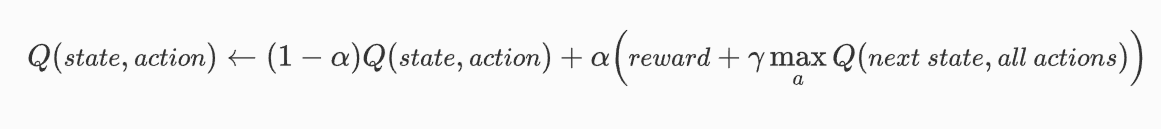

- Here, $\alpha$ - learning rate , the extent to which our Q-values are being updated in every iteration.

- $\gamma$ - discount factor, higher value implies giving much importance to long-term rewards , a value of 0 means it considers only immediate reward (Greedy)



### Creating the Q-table

In [8]:
import numpy as np

# initialize the Q-table -> (state X action) matrix
n_states = env.observation_space.n
n_actions = env.action_space.n

q_table = np.zeros([n_states, n_actions])

### Training

In [14]:
%%time
"""Training Algorithm"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        # Deciding whether to exploit or explore :
        if random.uniform(0, 1) < epsilon:  
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        max_among_next = np.max(q_table[next_state])
        
        # updating the Q-values according to the equation
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * max_among_next)
        q_table[state, action] = new_value
        

#         if reward == -10:
#             penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: total: 35.5 s
Wall time: 31.9 s


In [15]:
# Q-values at our illustration's state: 
state = 391
q_table[state]

array([ -2.49553105,  -2.48942084,  -2.49331044,  -2.48942084,
       -11.26798761, -10.9836251 ])

### Evaluation of our model

In [18]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 10
list_of_frames = []            # to visualise

for _ in range(episodes):
    observation = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    frames = []
    done = False
    
    while not done:
        action = np.argmax(q_table[observation])
        observation, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

    # Put each rendered frame into dictionary for animation(to be used later)
        frames.append({
            'frame': env.render(mode='ansi'),  
            'state': observation,
            'action': action,
            'reward': reward
            }
        )
        
        epochs += 1

    list_of_frames.append(frames)
    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 10 episodes:
Average timesteps per episode: 13.2
Average penalties per episode: 0.0


### Visualising our trained-model's performance (Evaluating)

In [22]:
from IPython.display import clear_output
from time import sleep

# print(frames[0]['frame'])

passenger_no = 0

def print_frames(frames):
    
    global passenger_no
    passenger_no += 1
    
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(f"Dropping off Passenger number :{passenger_no}")
        print(frame['frame'])               # display a popup window (animation)
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.5)
        
    sleep(1)
    


for frames in list_of_frames:
    print_frames(frames)

Dropping off Passenger number :10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 10
State: 410
Action: 5
Reward: 20


### No penalties => it performed the correct pickup/dropoff actions with 100 different passengers, without any illegal dropoff